# Ablation studies

In this notebook we give the scripts for various ablation studies resented in out paper:
- **Weights**<br>
    Verifying the role of the pair of constant shared weights used for `epsinas` computation.<br>
- **Computational performance**<br>
    Evaluation of FLOPs, memory and time related to epsinas calculation.

In [1]:
import os
import json
import time
import itertools

import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns
from tqdm import trange, tqdm
from scipy import stats
from thop import profile
from dotmap import DotMap
from statistics import mean
import matplotlib.pyplot as plt
from prettytable import PrettyTable

import torch.nn as nn
import torch

import nasspace
from datasets import data
from epsinas_utils import prepare_seed, compute_stats, plot_results, search_weights, compute_epsinas

2025-03-03 13:49:35.437808: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [2]:
dataset = 'cifar10'
data_loc = './datasets/cifardata'
batch_size = 256
repeat = 1
GPU = '0'
augtype = 'none'
trainval = False

In [3]:
# Arguments required for NAS-Bench-201 search space initialisation
args = DotMap()

args.api_loc = './nasbench_only108.tfrecord'
args.nasspace = 'nasbench101'
args.dataset = dataset
args.stem_out_channels = 128
args.num_stacks = 3
args.num_modules_per_stack = 3
args.num_labels = 1

savedataset = dataset
dataset = 'fake' if 'fake' in savedataset else savedataset
savedataset = savedataset.replace('fake', '')
if savedataset == 'cifar10':
    savedataset = savedataset + '-valid'

In [4]:
# Load the search space (it takes some time)
searchspace = nasspace.get_search_space(args)

Loading dataset from file... This may take a few minutes...
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Loaded dataset in 59 seconds


In [5]:
if 'valid' in savedataset:
    savedataset = savedataset.replace('-valid', '')
    
if args.dataset == 'cifar10':
    acc_type = 'ori-test'
    val_acc_type = 'x-valid'
else:
    acc_type = 'x-test'
    val_acc_type = 'x-valid'

In [6]:
# Define the device
os.environ['CUDA_VISIBLE_DEVICES'] = GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Randomly select n_samples architectures
prepare_seed(21)

In [7]:
# Load the data 
train_loader = data.get_data(dataset, data_loc, trainval, batch_size, augtype, repeat, args)

# Pick up a batch
data_iterator = iter(train_loader)
x, _= next(data_iterator)
x = x.to(device)

Files already downloaded and verified
Files already downloaded and verified


/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help` for usage information.


/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help` for usage information.




## Weight ablations

In this ablation study we verify how much does the performance of epsilon metric change depending on the chosen weights.

In [8]:
weight_range = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
it = 0
for weight_comb in itertools.product(weight_range, weight_range):
    weight_l = weight_comb[0]
    weight_h = weight_comb[1]
    
    if weight_h>weight_l:
        save_dir = f'../epsinas-release-data/NAS-Bench-101/ablation/weights/weights_{weight_l}_{weight_h}/'
        os.makedirs(save_dir, exist_ok=True)
        
        if os.path.exists(save_dir+'data'):
            # Load precomputed results
            data_file = open(save_dir+'data','rb')
            input_data = pkl.load(data_file)
            score = input_data["score"]
            accs_mean = input_data["accs_mean"]
            accs_min = input_data["accs_min"]
            accs_max = input_data["accs_max"]
            nparams = input_data["nparams"]
            datafile.close()
        else:
            accs_mean = []
            accs_min = []
            accs_max = []
            nparams = []
            score = []
            for i in trange(5000):
                uid = searchspace[i]
                network = searchspace.get_network(uid)
                network = network.to(device)
                preds = []
                for weight in [weight_l, weight_h]:
                    
                    torch.cuda.empty_cache()
                    prepare_seed(21)
                    
                    # Initialize
                    def initialize_resnet(m):
                        if type(m) == torch.nn.Sequential:
                            for sub_m in m:
                                initialize_resnet(sub_m)
                        else:
                            fill_bias = False
                            if hasattr(m, 'bias'):
                                if m.bias is not None:
                                    fill_bias = True

                            if fill_bias:
                                torch.nn.init.constant_(m.bias, 0)

                            fill_weight = False
                            if hasattr(m, 'weight'):
                                fill_weight = True

                            if hasattr(m, 'affine'):
                                if not m.affine:
                                    fill_weight = False

                            if fill_weight:
                                torch.nn.init.constant_(m.weight, weight)

                    network.apply(initialize_resnet)
                    y_pred, _ = network(x)
                    pred = y_pred.cpu().detach().numpy().flatten()
                    pred_min = np.nanmin(pred)
                    pred_max = np.nanmax(pred)
                    pred_norm = (pred - pred_min)/(pred_max - pred_min)
                    preds.append(pred_norm)

                # Compute the score
                preds = np.array(preds)
                preds[np.where(preds==0)] = np.nan
                mae = np.nanmean(np.abs(preds[0,:]-preds[1,:]))
                mean = np.nanmean(preds)

                score.append(mae/mean)
                nparams.append(sum(p.numel() for p in network.parameters()))
                accs_mean.append(searchspace.get_final_accuracy(uid, acc_type, args.trainval)[0])
                accs_min.append(searchspace.get_final_accuracy(uid, acc_type, args.trainval)[1])
                accs_max.append(searchspace.get_final_accuracy(uid, acc_type, args.trainval)[2]) 

            save_dic = {}
            save_dic["score"] = score
            save_dic["accs_mean"] = accs_mean
            save_dic["accs_min"] = accs_min
            save_dic["accs_max"] = accs_max
            save_dic["nparams"] = nparams
            pkl.dump(save_dic, open(save_dir + "Data", "wb"))
            
        if it==0:
            # Make the table
            headers = ["Weights", "Archs", "Spearman (global)", "Spearman (top-10%)", "Kendall (global)", "Kendall (top-10%)", "Top-10%/top-10%", "Top-64/top-5%"]
            table = PrettyTable(headers)
        stats, remain = compute_stats(score, accs_mean)
        stats_print = [f"[{weight_l}, {weight_h}]", remain] + stats     
        table.add_row(stats_print)
        it+=1
        
#         plot_results(score=score,
#                      accs=accs_mean,
#                      nparams=nparams,
#                      top10=False,
#                      log_scale=False,
#                      save_dir=save_dir,
#                      save_name="Epsilon_{}_{}.png".format(weight_l, weight_h))

In [9]:
table

Weights,Archs,Spearman (global),Spearman (top-10%),Kendall (global),Kendall (top-10%),Top-10%/top-10%,Top-64/top-5%
"[0.0001, 0.001]",2120,0.47,0.41,0.33,0.28,38.21,23.00
"[0.0001, 0.01]",2120,0.61,0.03,0.43,0.02,41.98,24.00
"[0.0001, 0.1]",2120,0.61,0.03,0.43,0.02,41.98,24.00
"[0.0001, 1]",2120,0.61,0.03,0.43,0.02,41.98,24.00
"[0.0001, 10]",2120,0.61,0.03,0.43,0.02,41.98,24.00
"[0.001, 0.01]",4968,0.29,-0.05,0.20,-0.03,17.30,10.00
"[0.001, 0.1]",4968,0.29,-0.05,0.19,-0.03,17.30,8.00
"[0.001, 1]",4968,0.29,-0.05,0.19,-0.03,17.30,8.00
"[0.001, 10]",4968,0.29,-0.05,0.19,-0.03,17.30,8.00
"[0.01, 0.1]",5000,0.21,-0.12,0.14,-0.08,4.60,0.00


## Computational cost tests

### FLOPS, memory, GPU time
Measuring FLOPS, memory usage and time it takes per architecture on a single GPU

In [11]:
# Assuming `searchspace` contains architectures
num_bins = 20  # Number of parameter ranges
weights = [1e-4, 10]

save_dir = "../epsinas-release-data/NAS-Bench-101/computational_efficiency/"
datafile = save_dir + "Computational_Efficiency_NASBench101.pkl"
if os.path.exists(datafile):
    with open(datafile, "rb") as f:
        bin_stats = pkl.load(f)
else:
    # Load the data 
    train_loader = data.get_data(dataset, data_loc, trainval, 1, augtype, repeat, args)

    # Pick up a batch
    data_iterator = iter(train_loader)
    x1, _= next(data_iterator)
    x1 = x1.to(device)

    # Prepare storage
    all_results = []

    # Iterate over 10000 randomly sampled architectures
    for i in tqdm(np.random.choice(len(searchspace), 10000)):
        uid = searchspace[i]
        arch = searchspace.get_network(uid)
        arch = arch.to(device)

        # Compute FLOPs with a batch size of one
        flops, nparams = profile(arch, inputs={x1,}, verbose=False)
        flops_mb = flops/(1024**2)

        # Sync before measuring memory
        torch.cuda.synchronize()
        torch.cuda.empty_cache()

        # Reset memory tracking
        torch.cuda.reset_peak_memory_stats(0)
        torch.cuda.synchronize()

        # Compute execution time of epsinas with a real batch of 256
        start_time = time.perf_counter()
        with torch.no_grad():
            eps_score = compute_epsinas(x, arch, weights)
        torch.cuda.synchronize()
        end_time = time.perf_counter()

        # Get peak memory usage
        del arch
        memory_used = torch.cuda.max_memory_allocated(0) / (1024**2) #convert to MB

        # Store results
        all_results.append((nparams, flops_mb, memory_used, end_time - start_time))
        torch.cuda.empty_cache()

    # Convert results to NumPy array
    all_results = np.array(all_results)
    nparams_all, flops_all, memory_all, time_all = all_results.T

    # Create bins for parameters
    param_bins = np.linspace(nparams_all.min(), nparams_all.max(), num_bins + 1)
    bin_indices = np.digitize(nparams_all, param_bins)

    # Compute mean and std for each bin
    bin_stats = []
    for i in range(1, num_bins + 1):
        mask = bin_indices == i
        if np.sum(mask) > 0:
            bin_stats.append({
                "param_range": (param_bins[i-1], param_bins[i]),
                "mean_flops": np.mean(flops_all[mask]),
                "std_flops": np.std(flops_all[mask]),
                "mean_memory": np.mean(memory_all[mask]),
                "std_memory": np.std(memory_all[mask]),
                "mean_time": np.mean(time_all[mask]),
                "std_time": np.std(time_all[mask]),
            })

    # Save results
    with open(datafile, "wb") as f:
        pkl.dump(bin_stats, f)

    print(f"Results saved to {save_dir}")

### CPU time

In [12]:
import psutil

save_dir = "../epsinas-release-data/NAS-Bench-101/computational_efficiency/"
datafile = save_dir + "Computational_Efficiency_NASBench101_CPU.pkl"
if os.path.exists(datafile):
    with open(datafile, "rb") as f:
        bin_stats = pkl.load(f)
else:

    # Load the data 
    train_loader = data.get_data(dataset, data_loc, trainval, 1, augtype, repeat, args)

    # Pick up a batch
    data_iterator = iter(train_loader)
    x1, _= next(data_iterator)
    x1 = x1.to(device)

    # Moving the data to CPU
    device = torch.device("cpu")
    x = x.to(device)
    x1 = x1.to(device)

    def get_memory_usage():
        # Get the current process ID
        process = psutil.Process(os.getpid())
        # Get memory usage in bytes
        memory_info = process.memory_info()
        return memory_info.rss  # Return in bytes (Resident Set Size)

    # Prepare storage
    all_results = []

    # Iterate over 10000 randomly sampled architectures
    for i in tqdm(np.random.choice(len(searchspace), 10000)):
        uid = searchspace[i]
        arch = searchspace.get_network(uid)
        arch = arch.to(device)

        # Compute FLOPs with a batch size of one
        flops, nparams = profile(arch, inputs={x1,}, verbose=False)
        flops_mb = flops/(1024**2)

        memory_before = get_memory_usage()
        # Compute execution time of epsinas with a real batch of 256
        start_time = time.perf_counter()
        with torch.no_grad():
            eps_score = compute_epsinas(x, arch, weights)
        end_time = time.perf_counter()

        del arch

        # Store results
        all_results.append((end_time - start_time))
        torch.cuda.empty_cache()

    # Convert results to NumPy array
    all_results = np.array(all_results)
    time_all = all_results.T

    # Create bins for parameters
    param_bins = np.linspace(nparams_all.min(), nparams_all.max(), num_bins + 1)
    bin_indices = np.digitize(nparams_all, param_bins)

    # Compute mean and std for each bin
    bin_stats = []
    for i in range(1, num_bins + 1):
        mask = bin_indices == i
        if np.sum(mask) > 0:
            bin_stats.append({
                "mean_time_cpu": np.mean(time_all[mask]),
                "std_time_cpu": np.std(time_all[mask]),
            })

    # Save results
    with open(datafile, "wb") as f:
        pkl.dump(bin_stats, f)

### Final computational performance plot

In [14]:
import pickle as pkl

# Load results
save_dir = "../epsinas-release-data/NAS-Bench-101/computational_efficiency/"
datafile = save_dir + "Computational_Efficiency_NASBench101.pkl"
with open(datafile, "rb") as f:
    bin_stats = pkl.load(f)
    
# Load results
save_dir = "../epsinas-release-data/NAS-Bench-101/computational_efficiency/"
datafile = save_dir + "Computational_Efficiency_NASBench101_CPU.pkl"
with open(datafile, "rb") as f:
    bin_stats_cpu = pkl.load(f)

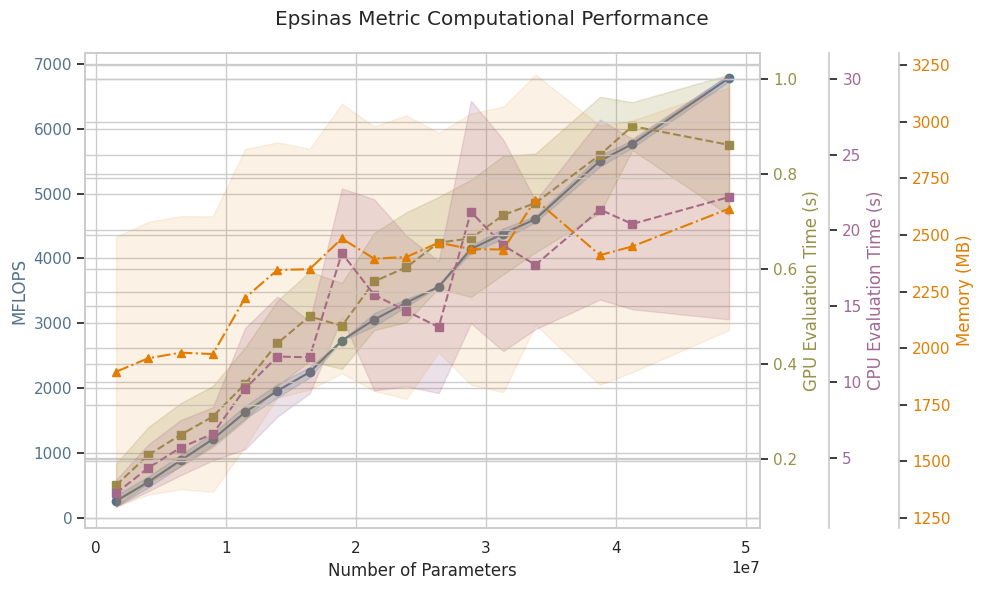

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Extract values for plotting
param_midpoints = np.array([(b["param_range"][0] + b["param_range"][1]) / 2 for b in bin_stats])

mean_flops = np.array([b["mean_flops"] for b in bin_stats])
std_flops = np.array([b["std_flops"] for b in bin_stats])

mean_memory = np.array([b["mean_memory"] for b in bin_stats])
std_memory = np.array([b["std_memory"] for b in bin_stats])

mean_time_gpu = np.array([b["mean_time"] for b in bin_stats])
std_time_gpu = np.array([b["std_time"] for b in bin_stats])

mean_time_cpu = np.array([b["mean_time_cpu"] for b in bin_stats_cpu])
std_time_cpu = np.array([b["std_time_cpu"] for b in bin_stats_cpu])

# Set Seaborn style
sns.set(style="whitegrid")

# Create the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# FLOPs (left y-axis)
ax1.set_xlabel("Number of Parameters")
ax1.set_ylabel("MFLOPS", color="#52728e")
ax1.errorbar(param_midpoints, mean_flops, fmt="-o", color="#52728e", label="FLOPS")
ax1.tick_params(axis="y", labelcolor="#52728e")
ax1.fill_between(param_midpoints, mean_flops - std_flops, mean_flops + std_flops, alpha=0.2, color="tab:blue")

# Evaluation time (GPU)
ax2 = ax1.twinx()
ax2.set_ylabel("GPU Evaluation Time (s)", color="#969147")
ax2.errorbar(param_midpoints, mean_time_gpu, color="#969147", linestyle='dashed', marker='s')
ax2.tick_params(axis="y", labelcolor="#969147")
ax2.fill_between(param_midpoints, mean_time_gpu - std_time_gpu, mean_time_gpu + std_time_gpu, alpha=0.2, color="#969147")

# Evaluation time (CPU)
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 50))
ax3.set_ylabel("CPU Evaluation Time (s)", color="#a16895")
ax3.errorbar(param_midpoints, mean_time_cpu, color="#a16895", linestyle='dashed', marker='s')
ax3.tick_params(axis="y", labelcolor="#a16895")
ax3.fill_between(param_midpoints, mean_time_cpu - std_time_cpu, mean_time_cpu + std_time_cpu, alpha=0.2, color="#a16895")

# Memory (MB)
ax4 = ax1.twinx()
ax4.spines["right"].set_position(("outward", 100))  # Offset to avoid overlap
ax4.errorbar(param_midpoints, mean_memory, color="#e37d00", linestyle='-.', marker='^')
ax4.set_ylabel("Memory (MB)", color="#e37d00")
ax4.tick_params(axis="y", labelcolor="#e37d00")
ax4.fill_between(param_midpoints, mean_memory - std_memory, mean_memory + std_memory, alpha=0.1, color="#e37d00")

# Title and layout adjustments
fig.suptitle("Epsinas Metric Computational Performance")
fig.tight_layout()
# plt.savefig(save_dir + "ComputationalEfficiency_NASBench101.pdf",
#             bbox_inches='tight', 
#             dpi=300,
#             format='pdf')
plt.show()